In [23]:
import os
import sys
import numpy as np
import networkx as nx
import pandas as pd
from collections import defaultdict


# Check if the notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    root_dir = f"/content/eeg-connectivity"
except ImportError:
    IN_COLAB = False
    root_dir = "."

# Clone the repository if in Colab
if IN_COLAB:
    !pip install pingouin==0.5.5 # Install needed stats library
    !git clone https://github.com/orion-junkins/eeg-connectivity.git # Clone repo
    if os.path.exists(root_dir):
        sys.path.append(root_dir) # Add cloned repo to Python path in colab
        print(f"Cloned connectivity repository and added to Python import path.")
    else:
        print(f"Failed to clone repository.")    
else:
    print("Not running in Google Colab. Skipping repository cloning.")

Not running in Google Colab. Skipping repository cloning.


In [24]:
# Imports
from plotting_utils import plot_heatmap, plot_stacked_triple_ps, plot_connectivity, dict_to_latex_table
from stats_tests import run_mixed_anova, run_rm_anova
from dataset import Dataset

In [25]:
# Load the dataset with all data in the folder "connectivity_scores_shannon_entropy"
data_dir = os.path.join(root_dir, "data")
dataset = Dataset('connectivity_scores_entropy_5s', expert_excludes=["11, 13b", "1"], novice_excludes=["13", "6", "14"], entropy_analysis=True, data_dir=data_dir)
frequency_bands = ["delta", "theta", "low alpha", "high alpha", "low beta", "high beta"]

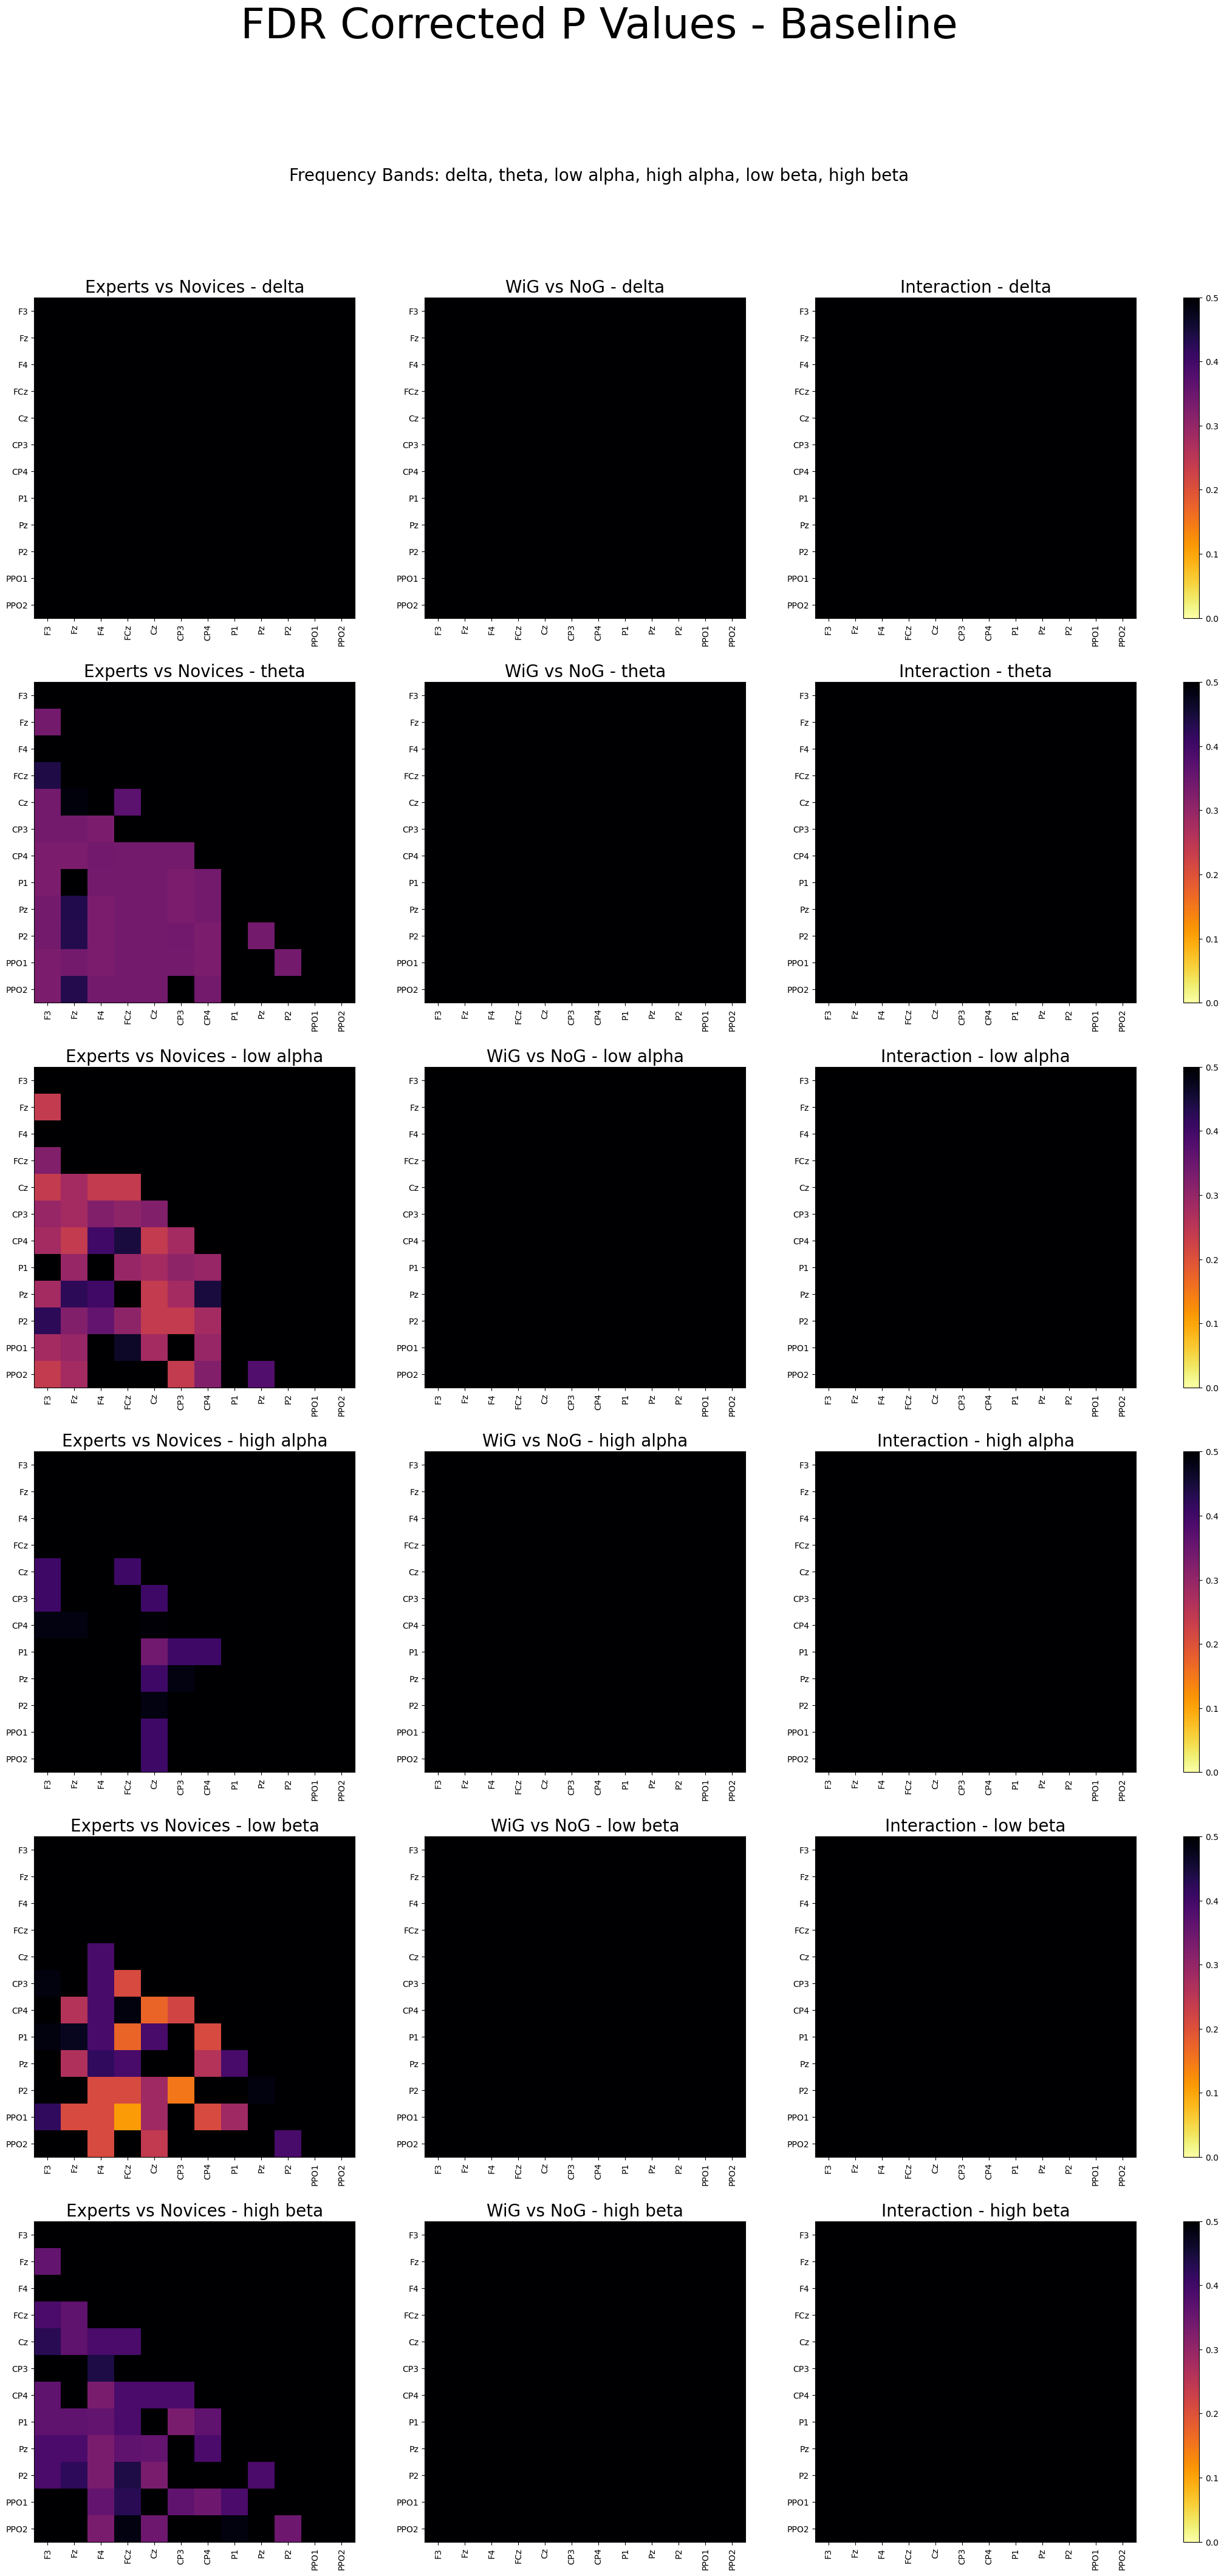

In [26]:
# Store lists of p values with one entry for each frequency band
bl_group_ps_fdr_corrected = []
bl_condition_ps_fdr_corrected = []
bl_interaction_ps_fdr_corrected = []
bl_n2_condition = []

# Iterate through bl frequency bands and run ANOVA tests for each
for freq in frequency_bands:
    # Define Group A as experts and Group B as novices
    # Define Condition 1 as WiG and Condition 2 as NoG
    group_a_condition_1 = dataset.get_frequency_average("expert", "BL", "WiG", freq)
    group_a_condition_2 = dataset.get_frequency_average("expert", "BL", "NoG", freq)

    group_b_condition_1 = dataset.get_frequency_average("novice", "BL", "WiG", freq)
    group_b_condition_2 = dataset.get_frequency_average("novice", "BL", "NoG", freq)

    # Run FDR Corrected Mixed ANOVA test
    p_values_group, p_values_condition, p_values_interaction, n2_condition = run_mixed_anova(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2, fdr_correct=True)

    # Store p values
    bl_group_ps_fdr_corrected.append(p_values_group)
    bl_condition_ps_fdr_corrected.append(p_values_condition)
    bl_interaction_ps_fdr_corrected.append(p_values_interaction)

    # Store effect size for condition
    bl_n2_condition.append(n2_condition)


# Plot p values fro group, condition, and interaction across all frequency bands
plot_stacked_triple_ps(bl_group_ps_fdr_corrected, bl_condition_ps_fdr_corrected, bl_interaction_ps_fdr_corrected, frequency_bands, dataset.electrode_names, title="FDR Corrected P Values - Baseline", sub_title_1="Experts vs Novices", sub_title_2="WiG vs NoG", sub_title_3="Interaction", save_path=None)

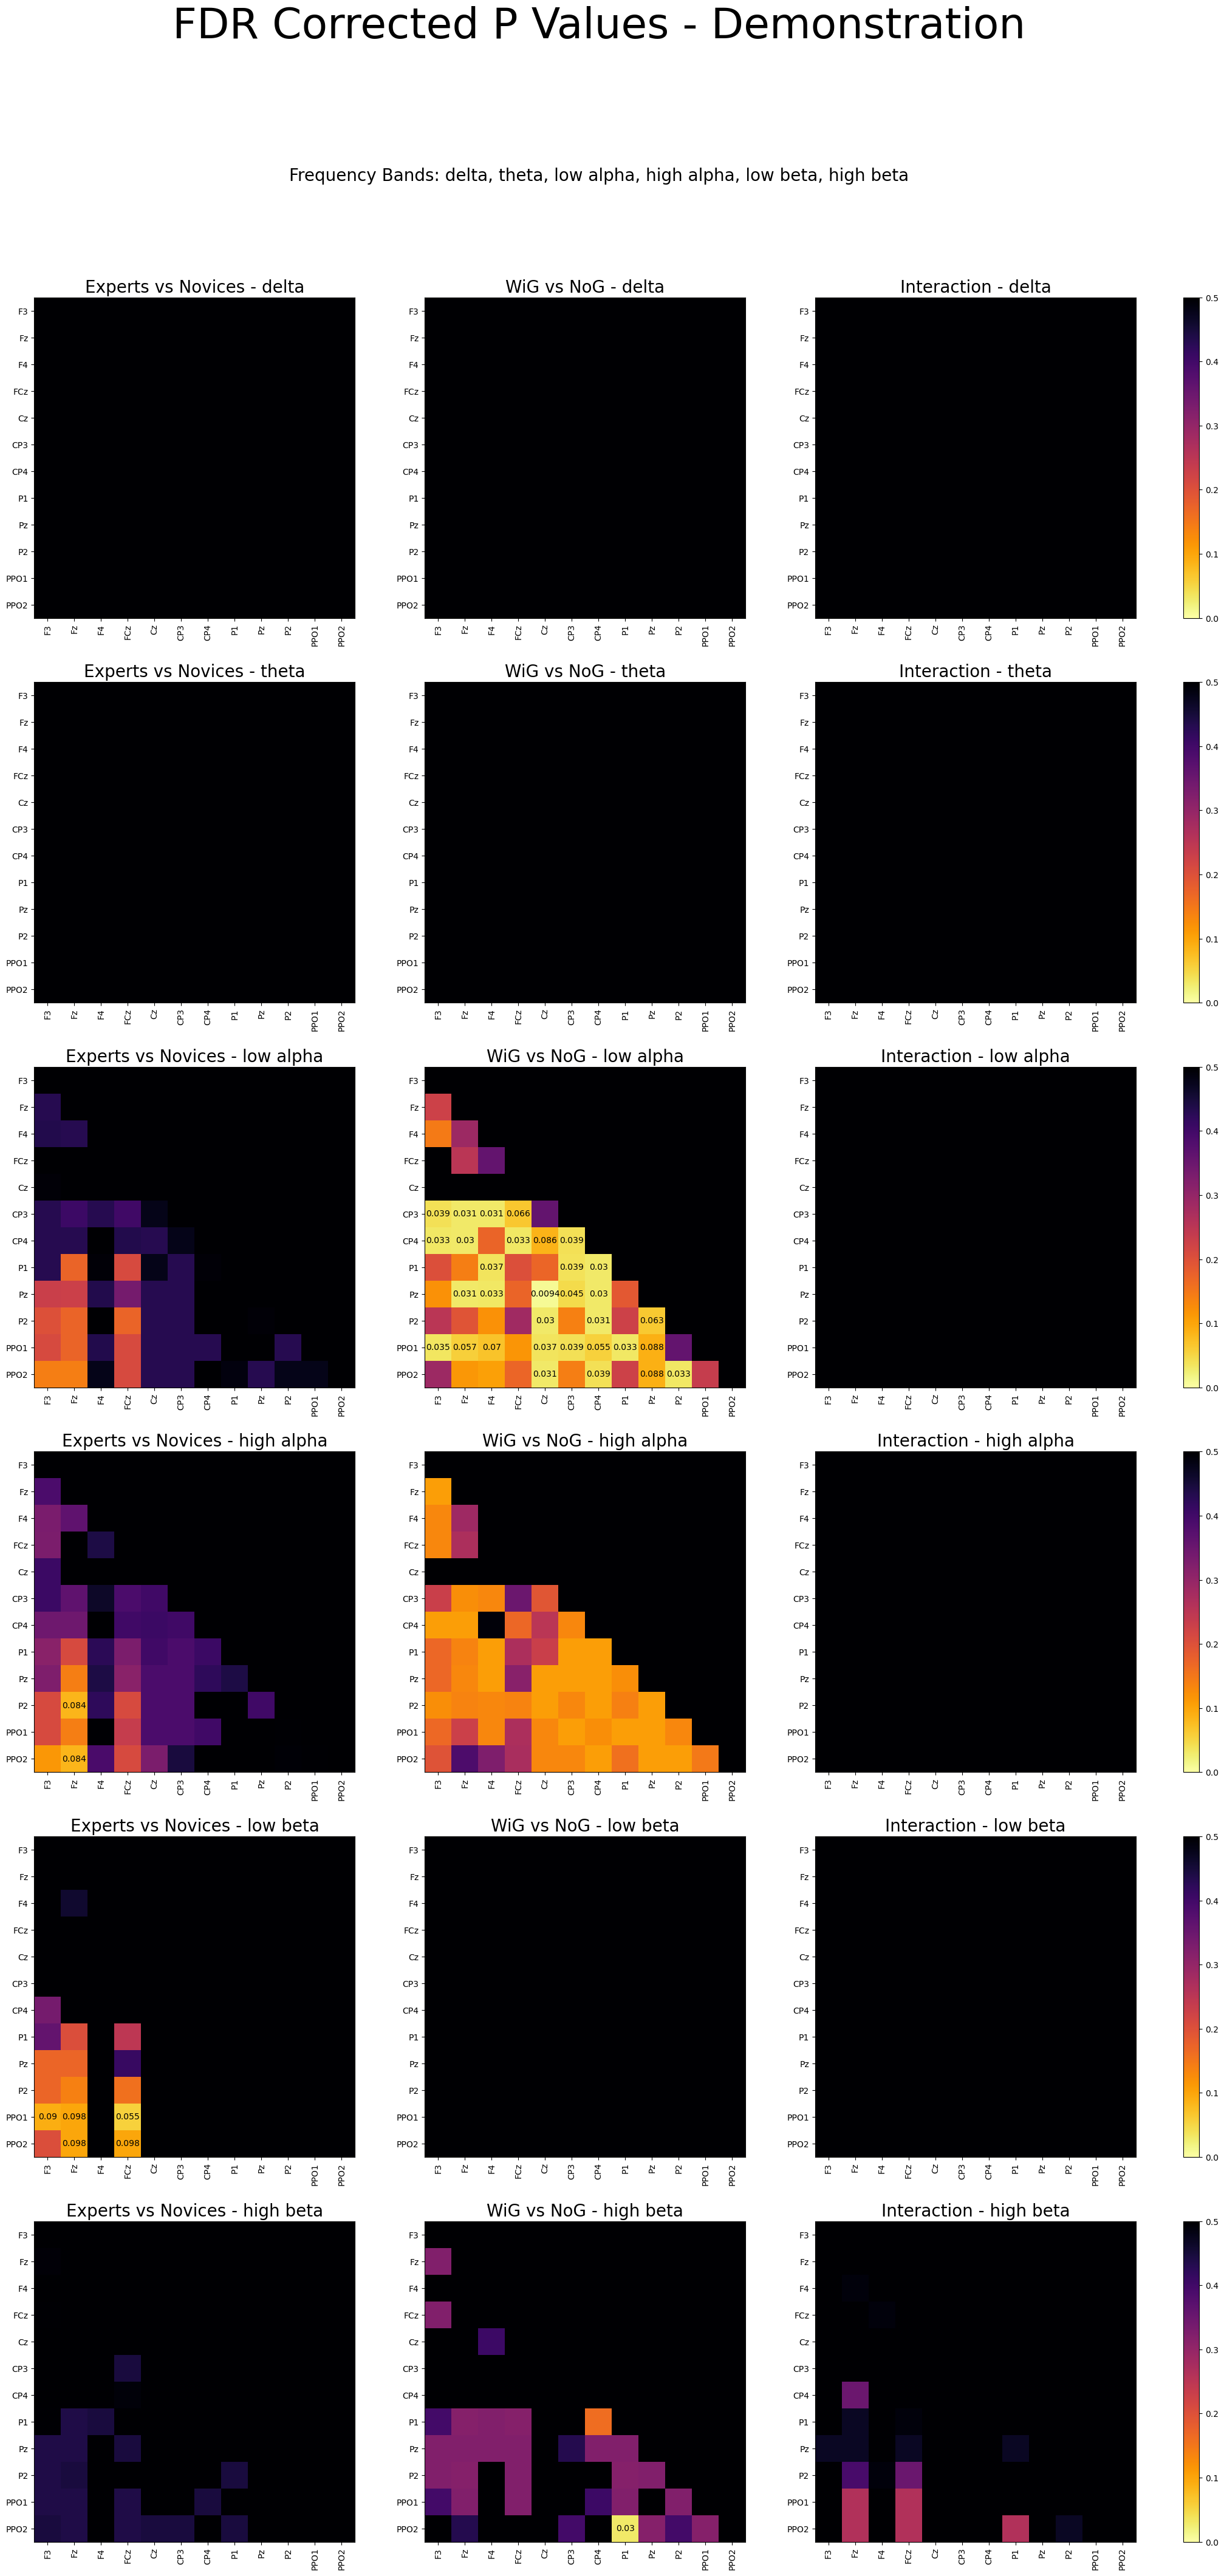

In [27]:
# Store lists of p values with one entry for each frequency band
demo_group_ps_fdr_corrected = []
demo_condition_ps_fdr_corrected = []
demo_interaction_ps_fdr_corrected = []


# Store list for effect size of condition
demo_n2_condition = []

# Iterate through bl frequency bands and run ANOVA tests for each
for freq in frequency_bands:
    # Define Group A as experts and Group B as novices
    # Define Condition 1 as WiG and Condition 2 as NoG
    group_a_condition_1 = dataset.get_frequency_average("expert", "demo", "WiG", freq)
    group_a_condition_2 = dataset.get_frequency_average("expert", "demo", "NoG", freq)

    group_b_condition_1 = dataset.get_frequency_average("novice", "demo", "WiG", freq)
    group_b_condition_2 = dataset.get_frequency_average("novice", "demo", "NoG", freq)

    # Run FDR Corrected Mixed ANOVA test
    p_values_group, p_values_condition, p_values_interaction, n2_condition = run_mixed_anova(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2, fdr_correct=True)

    # Store p values
    demo_group_ps_fdr_corrected.append(p_values_group)
    demo_condition_ps_fdr_corrected.append(p_values_condition)
    demo_interaction_ps_fdr_corrected.append(p_values_interaction)

    # Store effect size for condition
    demo_n2_condition.append(n2_condition)


# Plot p values fro group, condition, and interaction across all frequency bands
plot_stacked_triple_ps(demo_group_ps_fdr_corrected, demo_condition_ps_fdr_corrected, demo_interaction_ps_fdr_corrected, frequency_bands, dataset.electrode_names, title="FDR Corrected P Values - Demonstration", sub_title_1="Experts vs Novices", sub_title_2="WiG vs NoG", sub_title_3="Interaction", save_path=None)

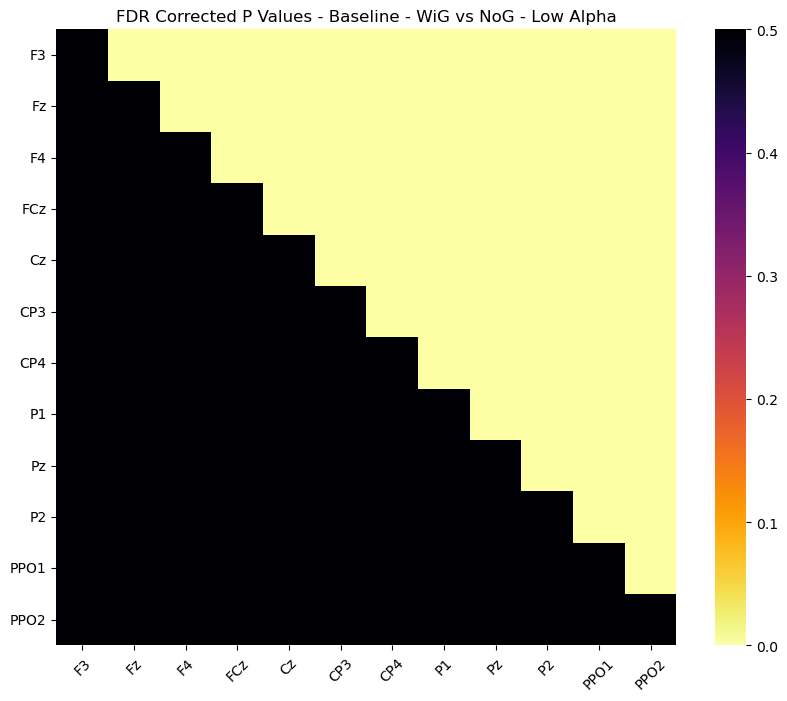

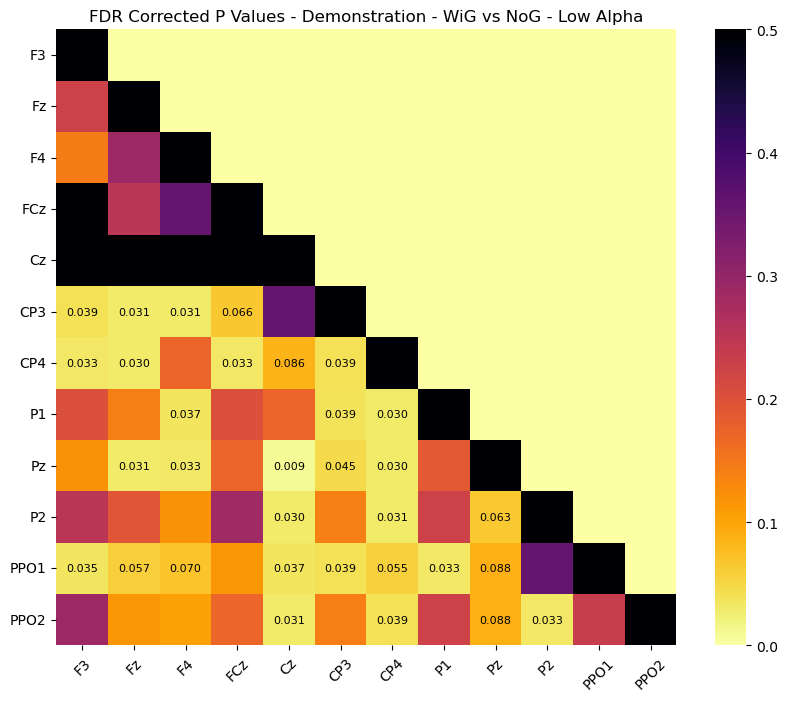

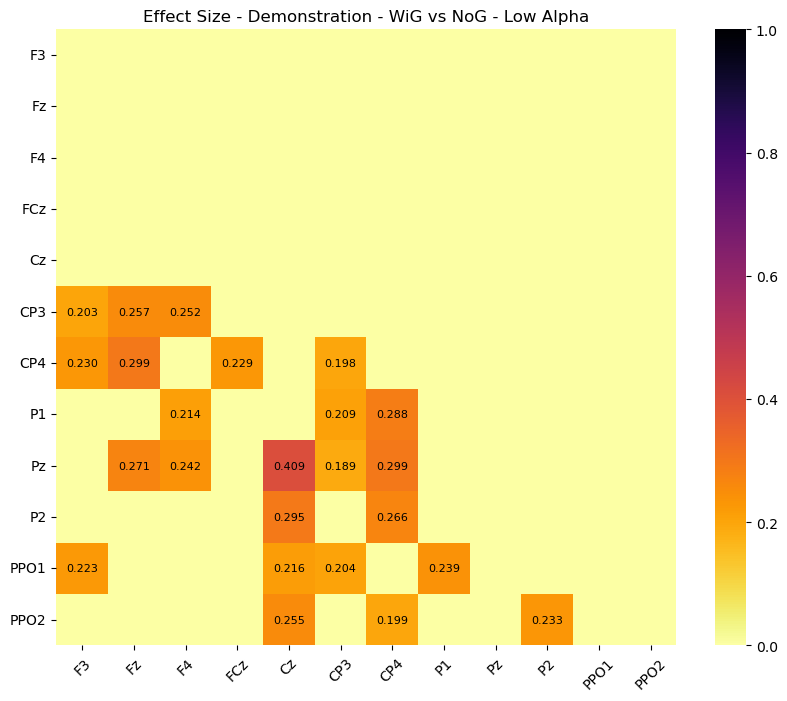

In [28]:
# Isolate the p values and effect sizes for the low alpha frequency band
p_values_low_alpha_bl = bl_condition_ps_fdr_corrected[2]
p_values_low_alpha_demo = demo_condition_ps_fdr_corrected[2]
n2_low_alpha_demo = demo_n2_condition[2]

# Construct a significance mask for p values less than 0.05 and effect sizes greater than 0.1
sig_mask_low_alpha_demo = (p_values_low_alpha_demo < 0.05) & (n2_low_alpha_demo > 0.06)

# Zero out non-significant values in the n2 array
n2_low_alpha_demo[~sig_mask_low_alpha_demo] = 0

plot_heatmap(p_values_low_alpha_bl, dataset.electrode_names, "FDR Corrected P Values - Baseline - WiG vs NoG - Low Alpha", vmin=0, vmax=0.5, print_max=0.1)
plot_heatmap(p_values_low_alpha_demo, dataset.electrode_names, "FDR Corrected P Values - Demonstration - WiG vs NoG - Low Alpha", vmin=0, vmax=0.5, print_max=0.1)
plot_heatmap(n2_low_alpha_demo, dataset.electrode_names, "Effect Size - Demonstration - WiG vs NoG - Low Alpha", vmin=0, vmax=1.0, print_min=0.1)

In [29]:
# Isolate Low Alpha data to study directionality of effect
expert_low_alpha_demo_wig = dataset.get_frequency_average("expert", "demo", "WiG", "low alpha")
novice_low_alpha_demo_wig = dataset.get_frequency_average("novice", "demo", "WiG", "low alpha")

expert_low_alpha_demo_nog = dataset.get_frequency_average("expert", "demo", "NoG", "low alpha")
novice_low_alpha_demo_nog = dataset.get_frequency_average("novice", "demo", "NoG", "low alpha")

expert_low_alpha_bl_wig = dataset.get_frequency_average("expert", "BL", "WiG", "low alpha")
novice_low_alpha_bl_wig = dataset.get_frequency_average("novice", "BL", "WiG", "low alpha")

expert_low_alpha_bl_nog = dataset.get_frequency_average("expert", "BL", "NoG", "low alpha")
novice_low_alpha_bl_nog = dataset.get_frequency_average("novice", "BL", "NoG", "low alpha")

# Combine experts and novices to compute mean difference
all_low_alpha_bl_nog = np.concatenate((expert_low_alpha_bl_nog, novice_low_alpha_bl_nog))
all_low_alpha_bl_wig = np.concatenate((expert_low_alpha_bl_wig, novice_low_alpha_bl_wig))

all_low_alpha_demo_nog = np.concatenate((expert_low_alpha_demo_nog, novice_low_alpha_demo_nog))
all_low_alpha_demo_wig = np.concatenate((expert_low_alpha_demo_wig, novice_low_alpha_demo_wig))

all_low_alpha_bl_diff = all_low_alpha_bl_wig - all_low_alpha_bl_nog
all_low_alpha_demo_diff = all_low_alpha_demo_wig - all_low_alpha_demo_nog

all_low_alpha_bl_mean_diff = np.mean(all_low_alpha_bl_diff, axis=0)
all_low_alpha_demo_mean_diff = np.mean(all_low_alpha_demo_diff, axis=0)

all_low_alpha_bl_std_diff = np.std(all_low_alpha_bl_diff, axis=0)
all_low_alpha_demo_std_diff = np.std(all_low_alpha_demo_diff, axis=0)

In [30]:
data_dict = defaultdict(list)

# Isolate significant connections and build the dataframe
sig_connections = []
for i in range(sig_mask_low_alpha_demo.shape[0]):
    for j in range(sig_mask_low_alpha_demo.shape[1]):
        if sig_mask_low_alpha_demo[i, j]:
            sig_connections.append((dataset.electrode_names[i], dataset.electrode_names[j]))
            data_dict["Electrode Pair"].append(dataset.electrode_names[i] + ", " + dataset.electrode_names[j])
            data_dict["P-Value (FDR Adj.)"].append(p_values_low_alpha_demo[i, j].round(3))
            data_dict["Effect Size"].append(n2_low_alpha_demo[i, j].round(3))
            data_dict["Mean Demo WiG-NoG (std)"].append(f'{all_low_alpha_demo_mean_diff[i, j].round(3)} ({all_low_alpha_demo_std_diff[i,j].round(3)})')
            data_dict["P-Value in Baseline (FDR Adj.)"].append(p_values_low_alpha_bl[i, j].round(3))
            
       
# Make a dataframe
df = pd.DataFrame(data_dict)

# Sort
df = df.sort_values(by="P-Value (FDR Adj.)", ascending=True)

# Drop index
df = df.reset_index(drop=True)

# Back to dict
sorted_data_dict = df.to_dict(orient="list")

# Convert to LaTeX table
latex_table_str = dict_to_latex_table(sorted_data_dict, col_width="2.0cm")

# Save to text file if not in Colab
if not IN_COLAB:
    output_path = "paper/tables/significant_connectivity.txt"
    with open(output_path, "w") as f:
        f.write(latex_table_str)

print(latex_table_str)

\begin{table}[h!]
  \centering
  \caption{Table X: Description...}
  \begin{tabular}{|p{2.0cm}|p{2.0cm}|p{2.0cm}|p{2.0cm}|p{2.0cm}|}
    \hline
    Electrode Pair & P-Value (FDR Adj.) & Effect Size & Mean Demo WiG-NoG (std) & P-Value in Baseline (FDR Adj.) \\ \hline
    Pz, Cz & 0.009 & 0.409 & -0.038 (0.046) & 1.0 \\ 
    CP4, Fz & 0.03 & 0.299 & -0.034 (0.052) & 1.0 \\ 
    P2, Cz & 0.03 & 0.295 & -0.031 (0.049) & 1.0 \\ 
    Pz, CP4 & 0.03 & 0.299 & -0.041 (0.066) & 1.0 \\ 
    P1, CP4 & 0.03 & 0.288 & -0.035 (0.055) & 1.0 \\ 
    CP3, Fz & 0.031 & 0.257 & -0.035 (0.059) & 1.0 \\ 
    CP3, F4 & 0.031 & 0.252 & -0.038 (0.066) & 1.0 \\ 
    PPO2, Cz & 0.031 & 0.255 & -0.028 (0.052) & 1.0 \\ 
    P2, CP4 & 0.031 & 0.266 & -0.04 (0.068) & 1.0 \\ 
    Pz, Fz & 0.031 & 0.271 & -0.036 (0.063) & 1.0 \\ 
    Pz, F4 & 0.033 & 0.242 & -0.035 (0.062) & 1.0 \\ 
    PPO1, P1 & 0.033 & 0.239 & -0.051 (0.096) & 1.0 \\ 
    PPO2, P2 & 0.033 & 0.233 & -0.057 (0.104) & 1.0 \\ 
    CP4, FCz & 0.033 & 0

In [34]:
# Display the data
df

,Electrode Pair,P-Value (FDR Adj.),Effect Size,Mean Demo WiG-NoG (std),P-Value in Baseline (FDR Adj.)
0,"Pz, Cz",0.009,0.409,-0.038 (0.046),1.0
1,"CP4, Fz",0.030,0.299,-0.034 (0.052),1.0
2,"P2, Cz",0.030,0.295,-0.031 (0.049),1.0
3,"Pz, CP4",0.030,0.299,-0.041 (0.066),1.0
4,"P1, CP4",0.030,0.288,-0.035 (0.055),1.0
5,"CP3, Fz",0.031,0.257,-0.035 (0.059),1.0
6,"CP3, F4",0.031,0.252,-0.038 (0.066),1.0
7,"PPO2, Cz",0.031,0.255,-0.028 (0.052),1.0
8,"P2, CP4",0.031,0.266,-0.04 (0.068),1.0
9,"Pz, Fz",0.031,0.271,-0.036 (0.063),1.0


Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

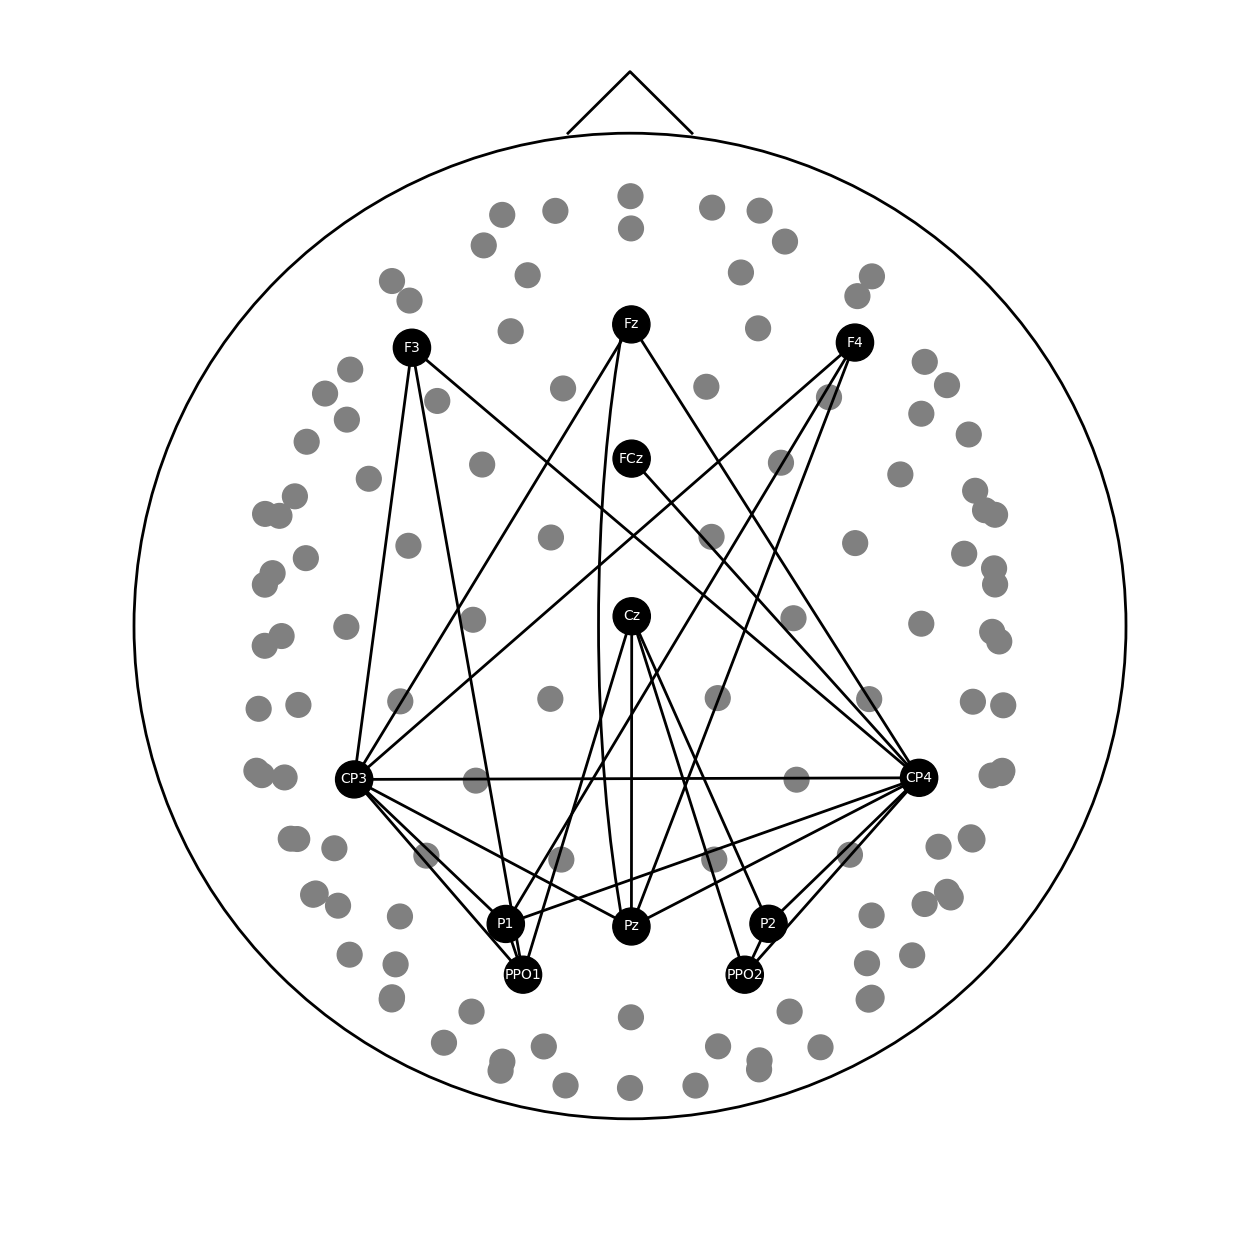

In [35]:
if not IN_COLAB:
    output_path = "paper/figures/connections.png"
    plot_connectivity(sig_connections, save_path=output_path)
else:
    plot_connectivity(sig_connections)

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

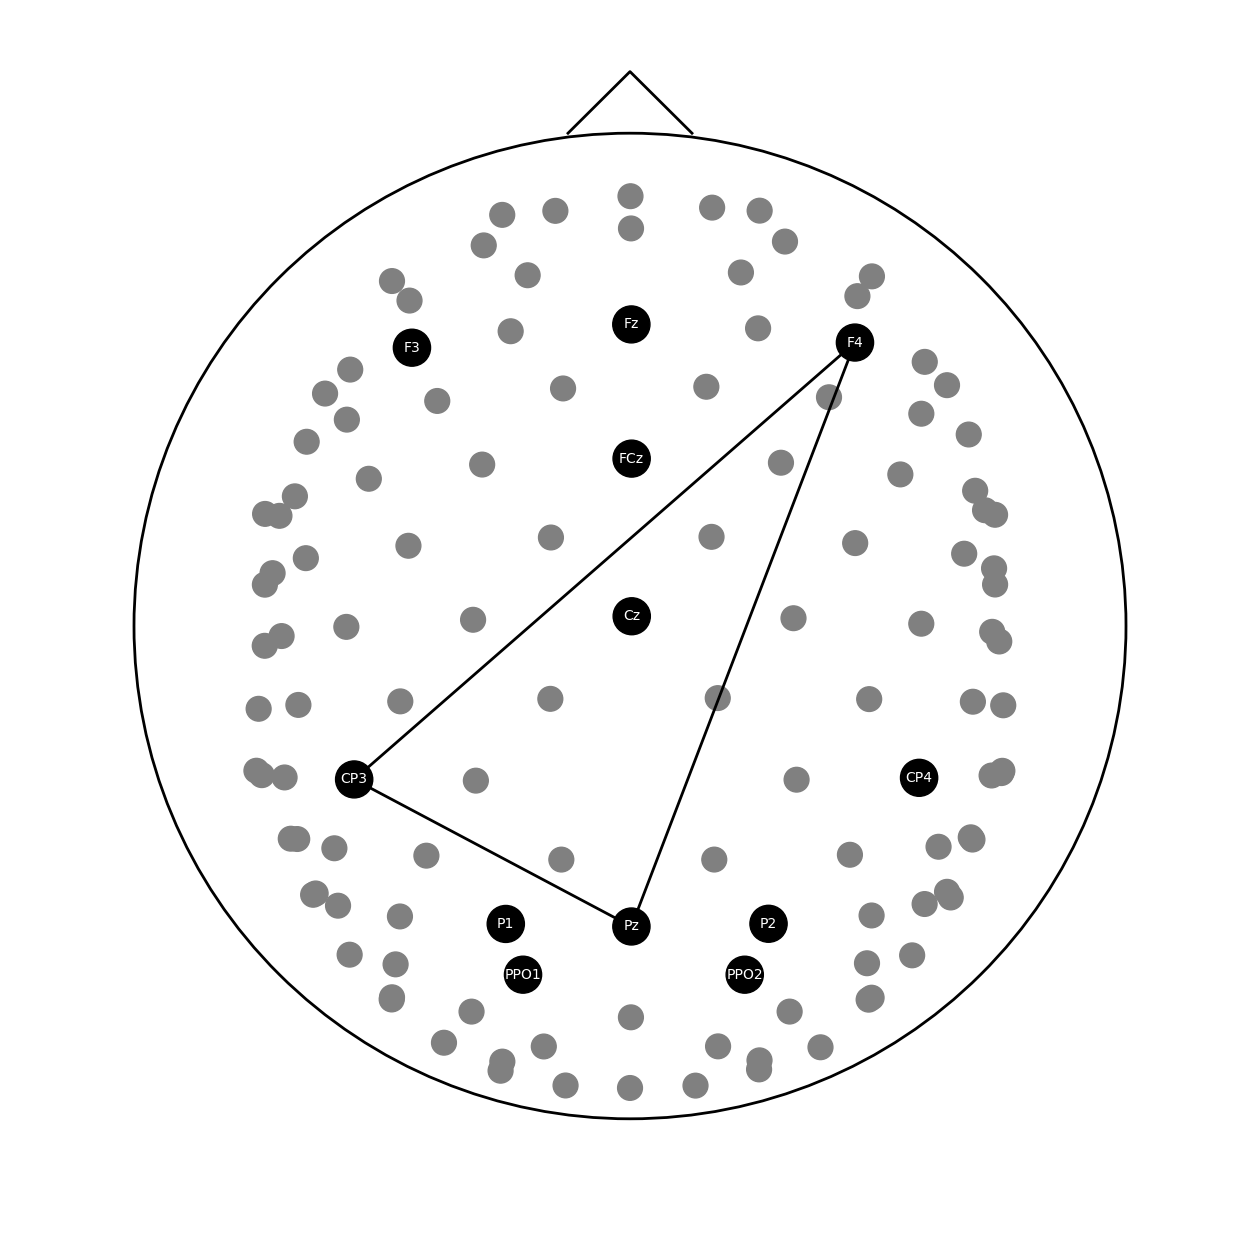

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

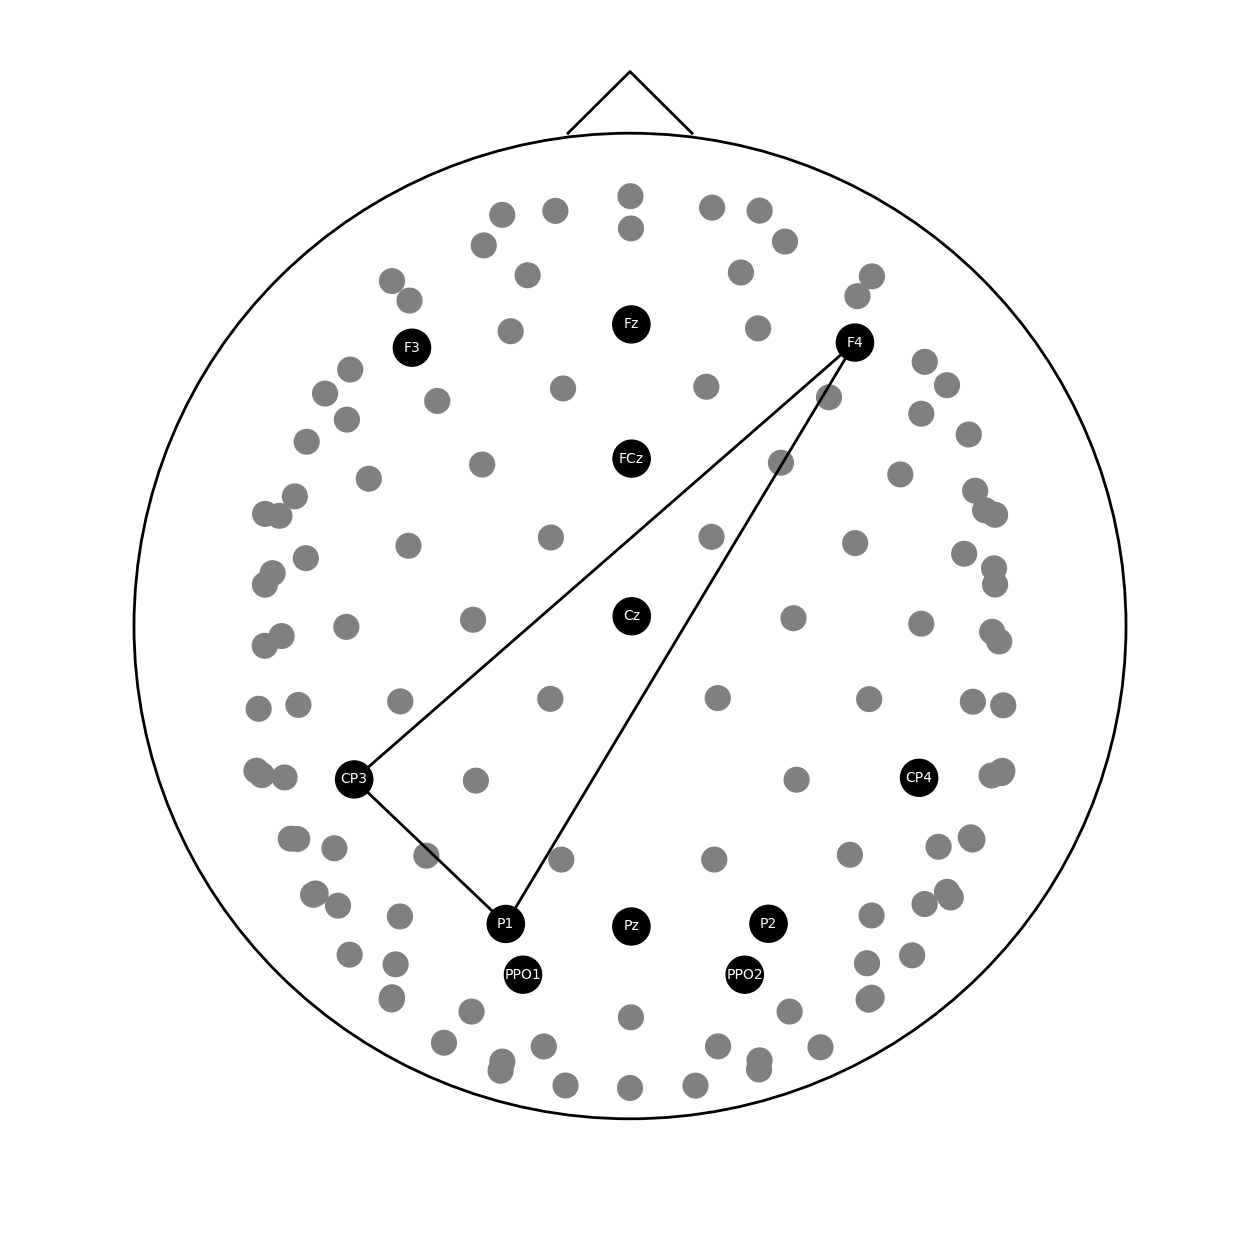

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

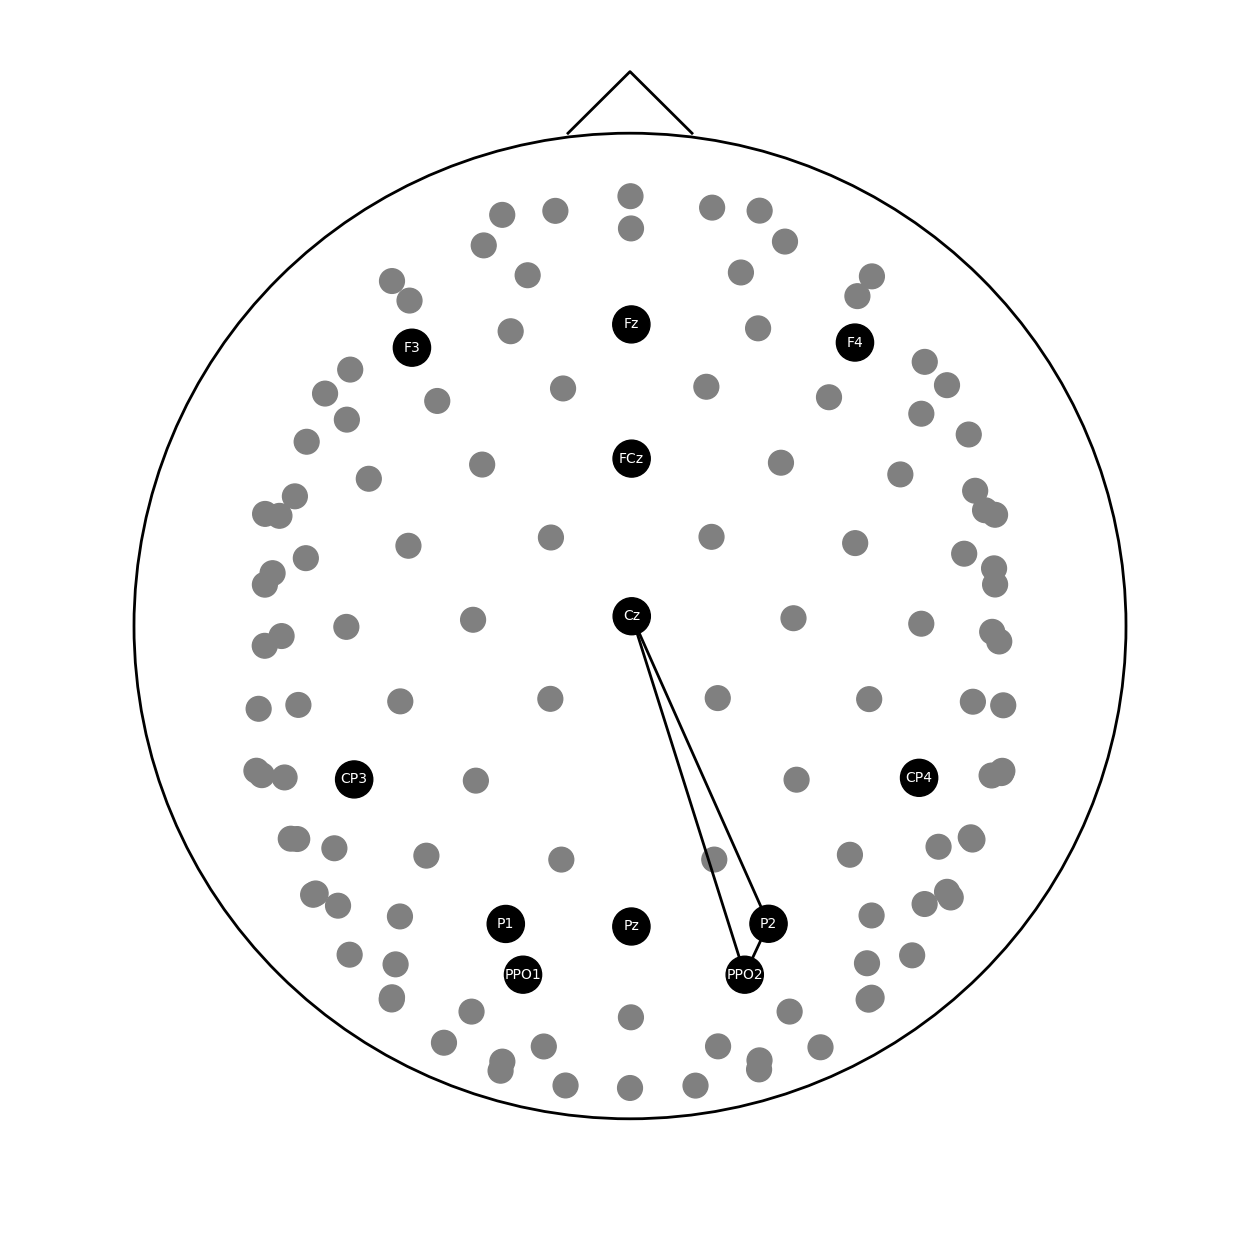

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

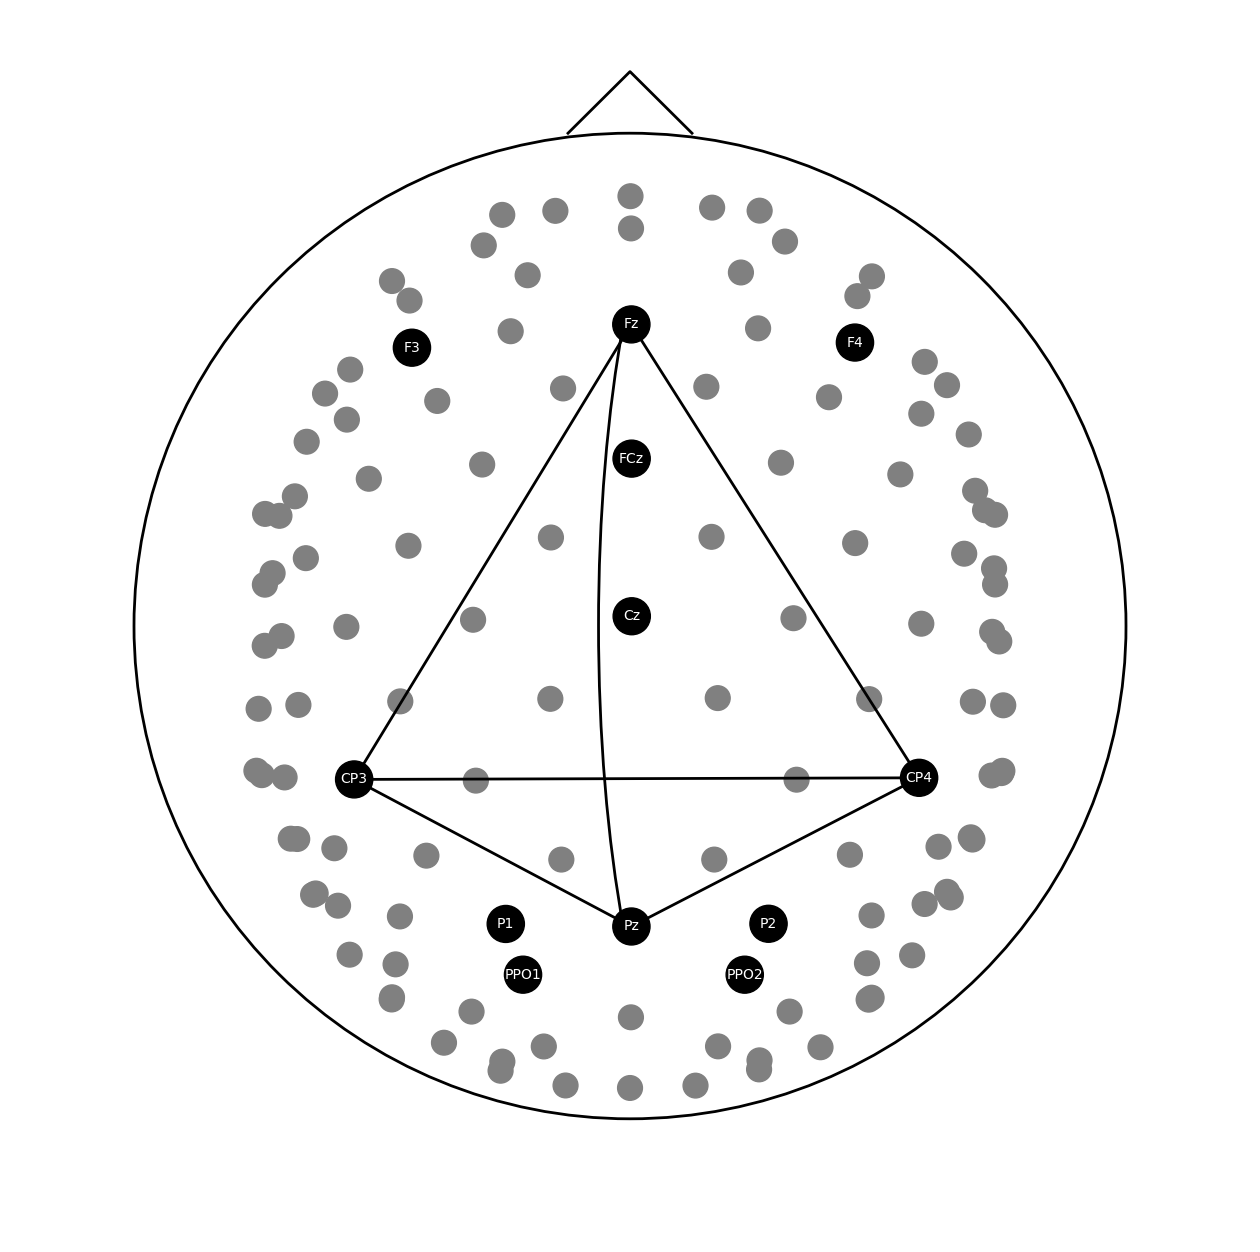

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

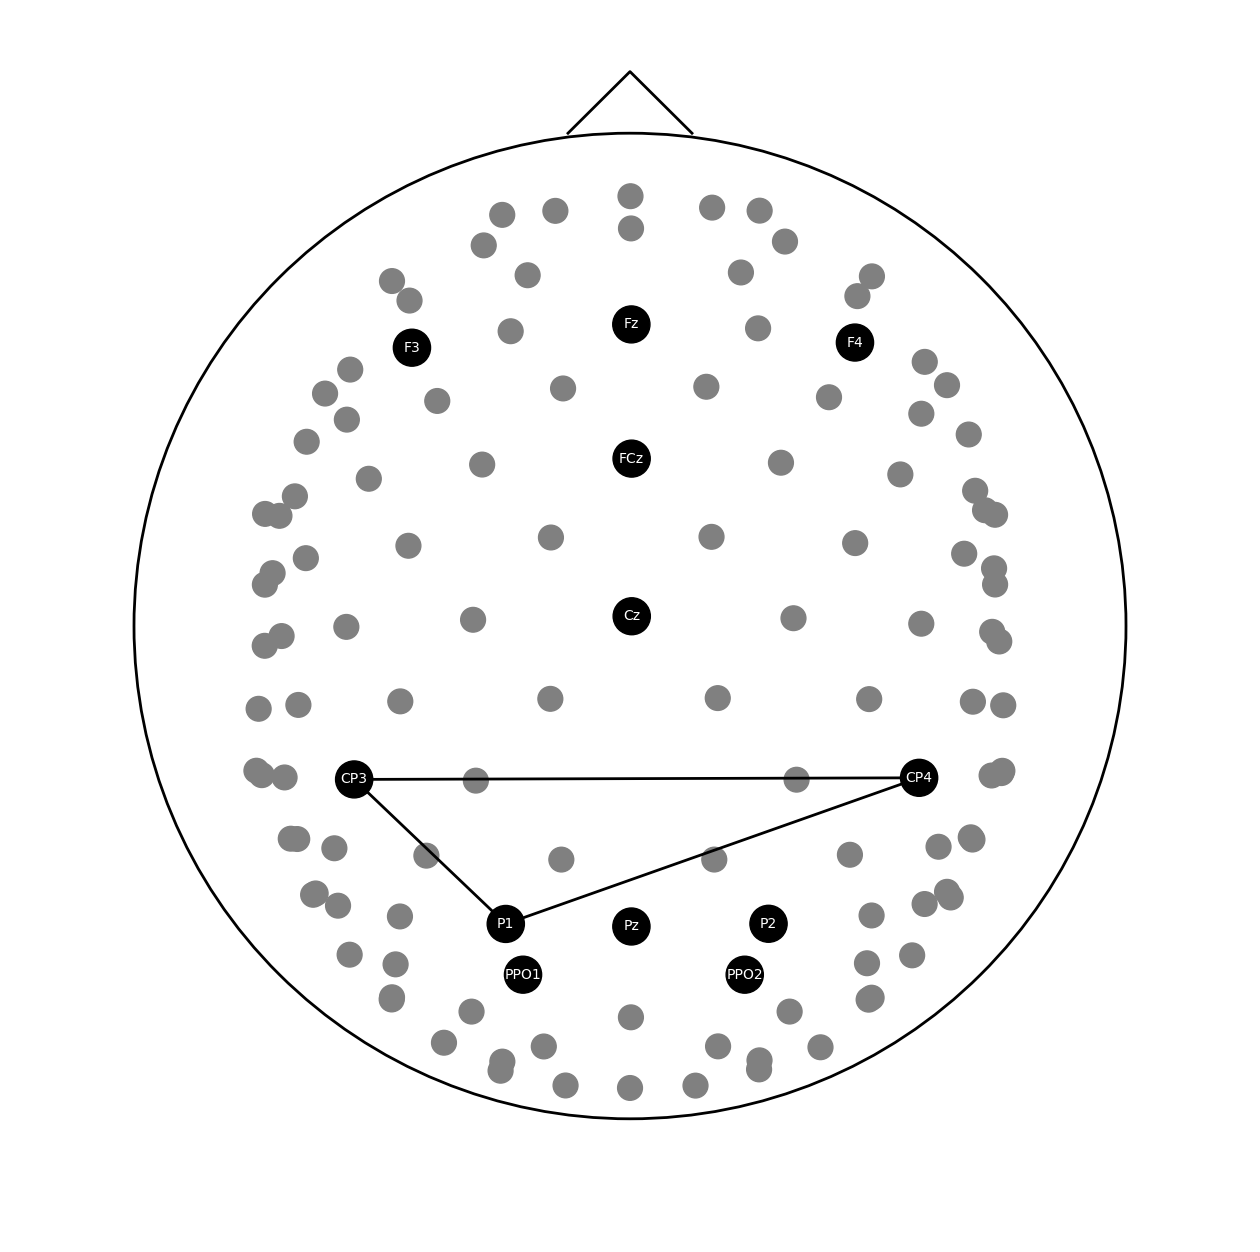

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

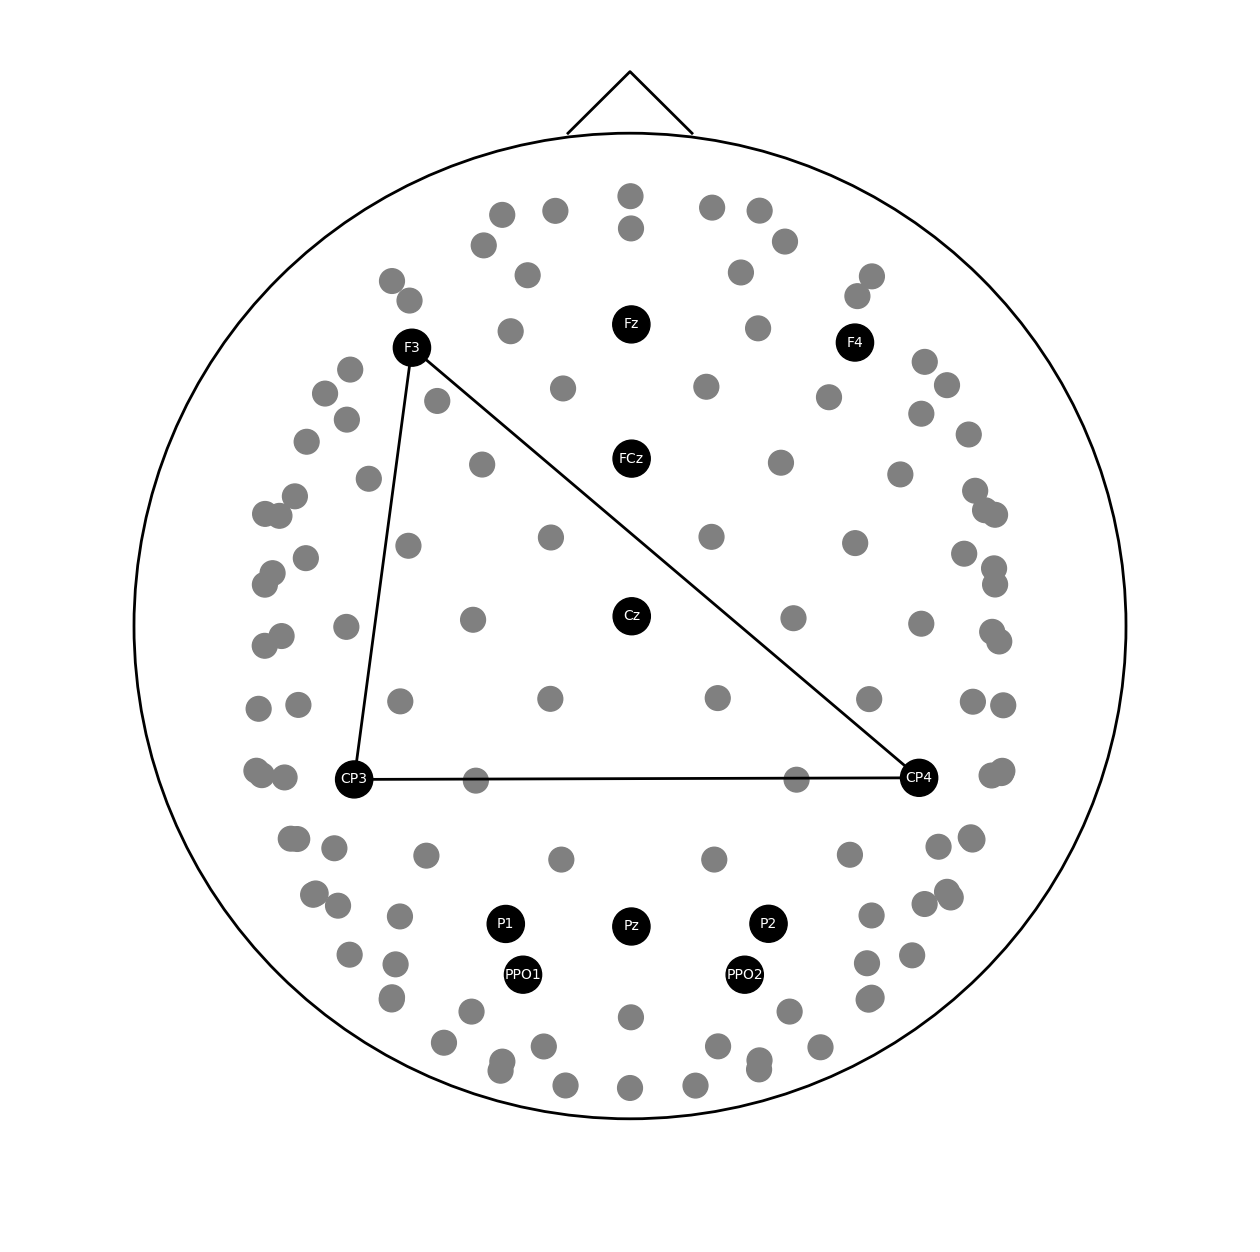

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

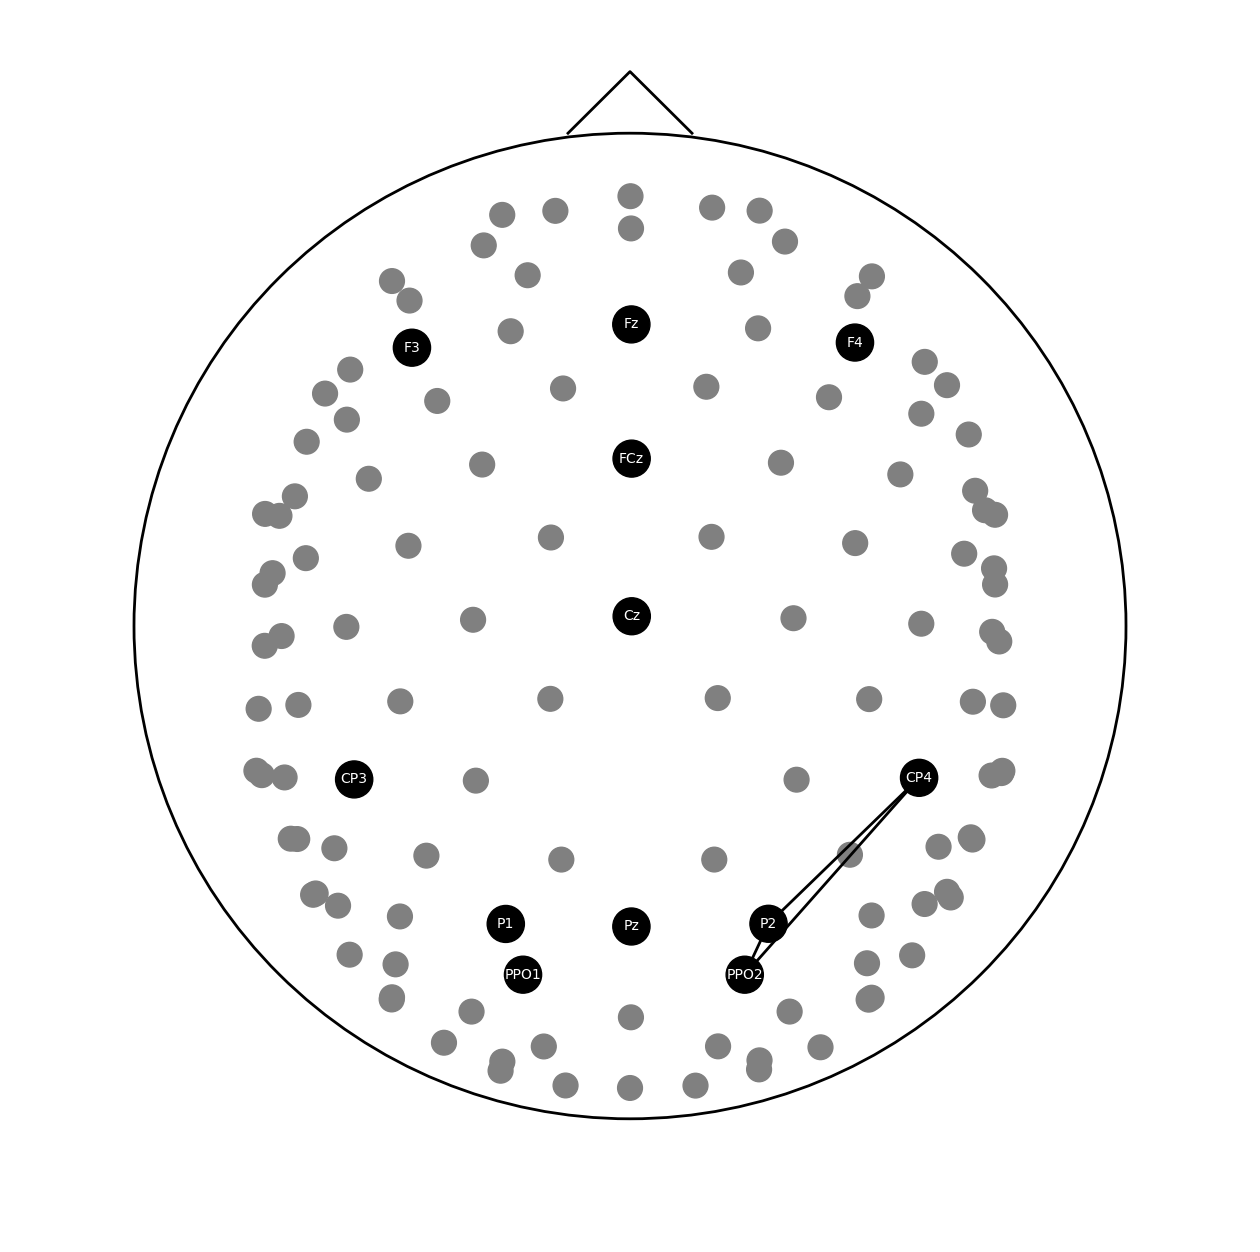

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

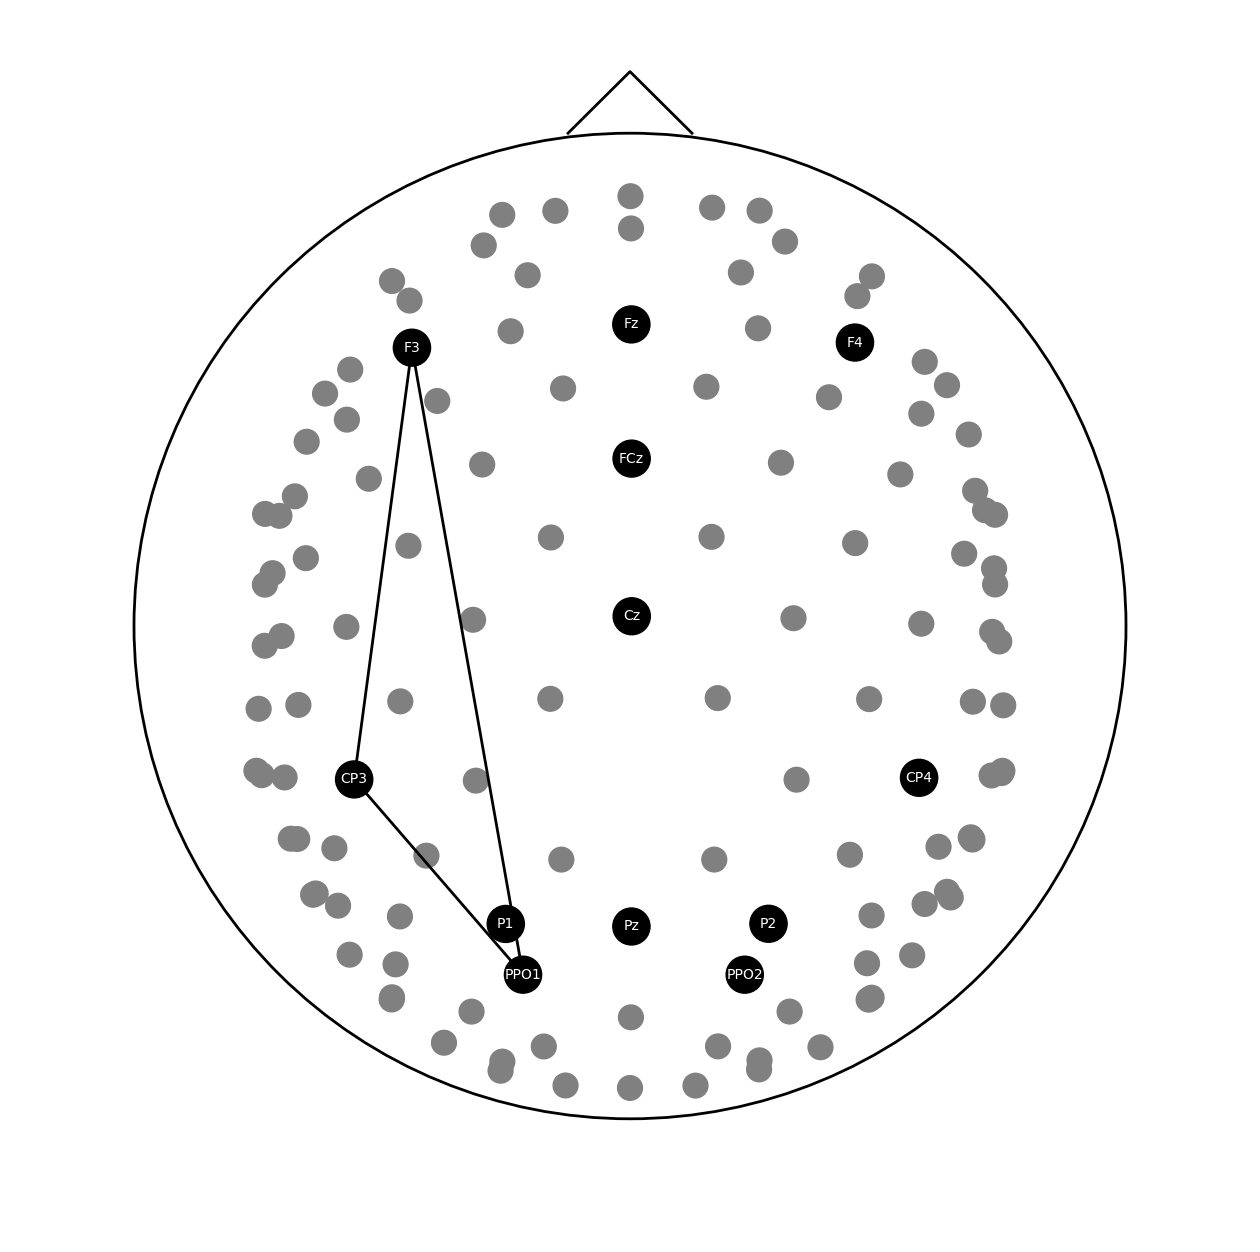

Opening raw data file /Volumes/eeg/processed/expert/1/1_0.9999_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 122) active
    Range : 0 ... 937879 =      0.000 ...  1831.795 secs
Ready.
{'Fp1': (-0.029436700000000007, 0.08391710000000001), 'Fpz': (0.00011229999999999327, 0.088247), 'Fp2': (0.029872299999999997, 0.08489590000000001), 'AF7': (-0.05483969999999999, 0.0685722), 'AF3': (-0.0337007, 0.0768371), 'AFz': (0.0002312999999999912, 0.08077099999999998), 'AF4': (0.0357123, 0.07772589999999999), 'AF8': (0.055743299999999996, 0.0696568), 'F7': (-0.07026290000000002, 0.042474300000000006), 'F5': (-0.0644658, 0.04803530000000001), 'F3': (-0.050243800000000005, 0.0531112), 'F1': (-0.027495800000000004, 0.0569311), 'Fz': (0.000312199999999997, 0.05851200000000001), 'F2': (0.029514199999999994, 0.057601900000000004), 'F4': (0.05183619999999999, 0.05430479999999999), 'F6': (0.0679142, 0.0498297), 'F8': (0.0730431, 0.04442170000000001), 'FT9': (-0.08407

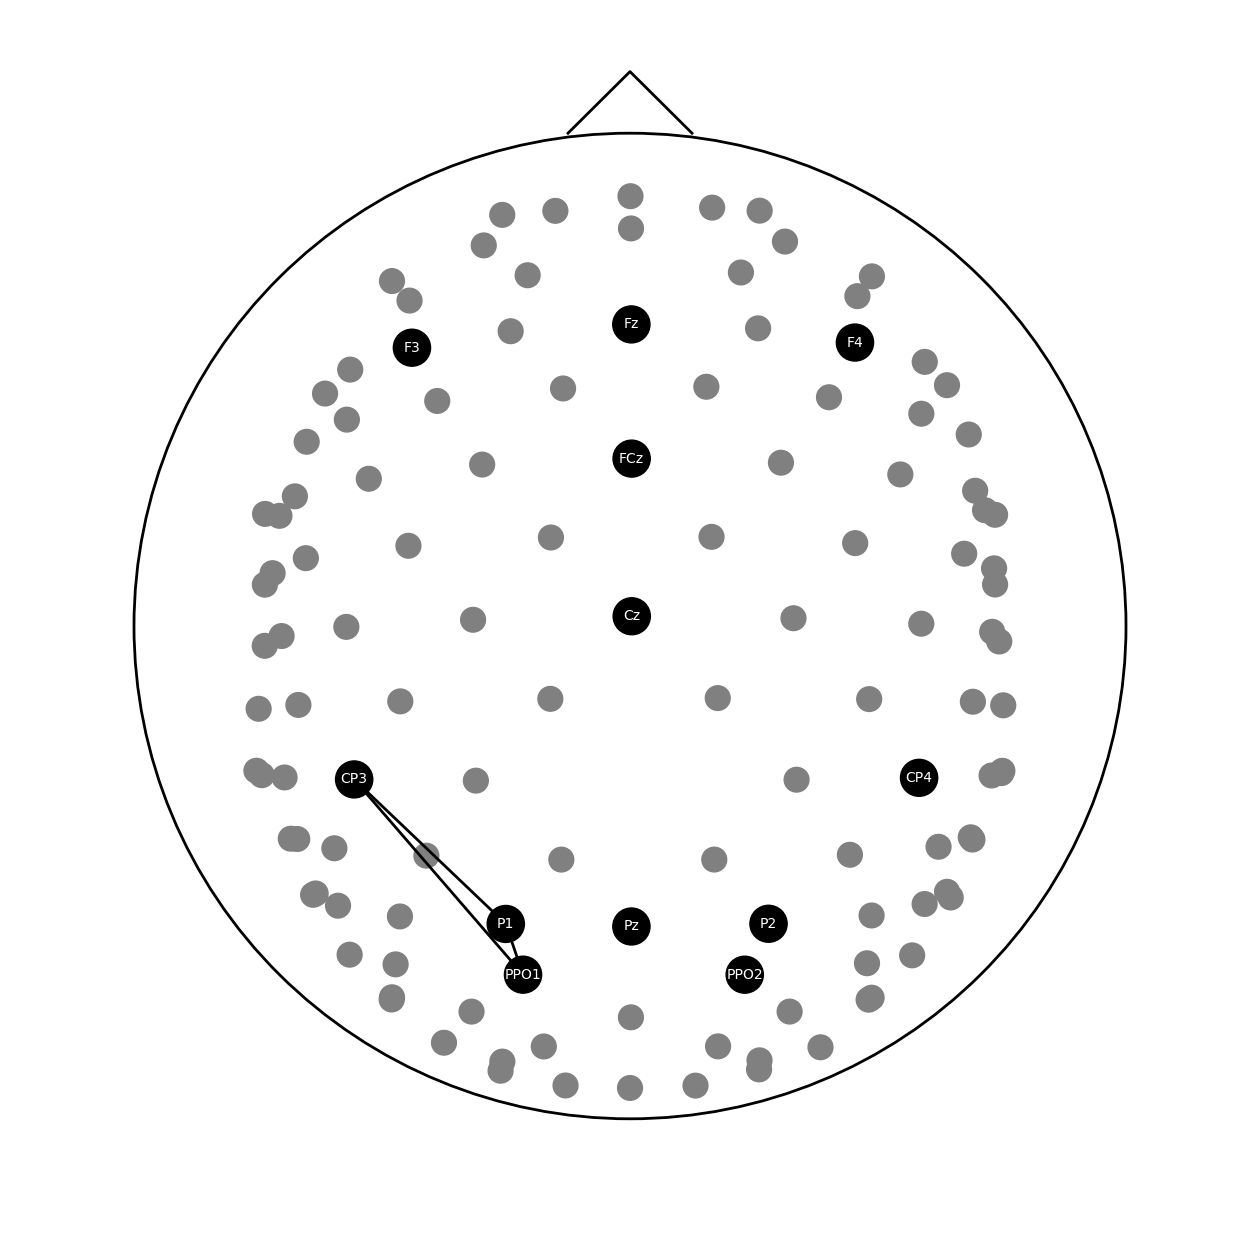

In [36]:
# Treat the connections as a graph to isolate cliques
G = nx.Graph()
G.add_edges_from(sig_connections)
cliques = list(nx.find_cliques(G))

# Visualize cliques with more than 2 nodes
for clique in cliques:
    if len(clique) < 3:
        continue
    # Create all possible permutations of the clique
    clique_sig_connections = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]

    if not IN_COLAB:
        output_path = "paper/figures/clique_" + "_".join(clique) + ".png"
        plot_connectivity(clique_sig_connections, save_path=output_path)
    else:
        plot_connectivity(clique_sig_connections)